In [1]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d

import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

index_count = len(train.columns) if len(train.columns) > len(test.columns) else len(test.columns)

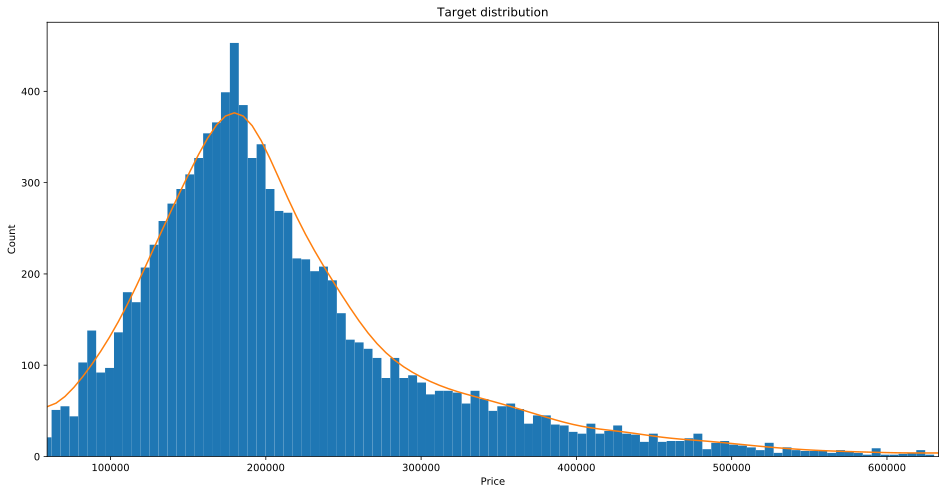

In [6]:
target_name = 'Price'

plt.figure(figsize = (16, 8))

n, bins, patches = plt.hist(train['Price'], bins=100, align='left')
plt.ylabel('Count')
plt.xlabel('Price')

n = np.insert(n, n.argmax(), n[n.argmax()])
nsmoothed = gaussian_filter1d(n, sigma=3)

ax = plt.subplot(111)
ax.set_xlim(bins[0], bins[-1])

plt.plot(bins, nsmoothed)

plt.title('Target distribution')
plt.show()

In [7]:
train = train.set_index('Id')

train.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [8]:
train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [9]:
train = pd.get_dummies(train)
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
Id,,,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,...,NaN,0,0,305018.871089,0,1,0,1,0,1
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,...,1183.0,1,0,177734.553407,0,1,0,1,0,1
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,...,240.0,3,1,282078.720850,0,1,0,1,0,1
2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,...,NaN,0,1,168106.007630,0,1,0,1,0,1
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,...,NaN,0,6,343995.102962,0,1,0,1,0,1


In [10]:
train.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price',
       'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
       'Shops_2_B'],
      dtype='object')

In [11]:
train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [19]:
train.loc[(train['Rooms'] < 1) | (train['Rooms'] > 9), ['DistrictId','Rooms','Square','LifeSquare','KitchenSquare','Social_2',target_name]]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Social_2,Price
Id,,,,,,,
5927,57,10.0,59.056975,36.223072,10.0,19083,317265.323792
3159,88,0.0,38.697117,19.345131,9.0,8429,158998.110646
14865,9,10.0,60.871266,38.420681,10.0,5648,172329.270863
7317,27,0.0,41.790881,NaN,0.0,1892,98129.976788
770,28,0.0,49.483501,NaN,0.0,6207,217009.338463
8491,1,19.0,42.006046,21.779288,7.0,264,78364.616704
9443,27,0.0,87.762616,85.125471,0.0,1892,219281.918007
7917,27,0.0,212.932361,211.231125,0.0,1892,302211.260887
456,6,0.0,81.491446,NaN,0.0,1564,212864.799112


In [23]:
train.groupby('DistrictId')['Square'].median()

DistrictId
0      48.998792
1      60.139271
2      47.362676
3      47.202193
4      53.179791
         ...    
202    68.245487
205    43.226985
207    76.780960
208    53.860839
209    33.533077
Name: Square, Length: 205, dtype: float64

In [24]:
train.groupby('DistrictId')['Price'].median()

DistrictId
0      165963.054142
1      183663.443595
2      208539.501373
3      169094.013281
4      278639.482329
           ...      
202    394150.861857
205    220501.566180
207    426186.409334
208    431137.654083
209    140048.802277
Name: Price, Length: 205, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

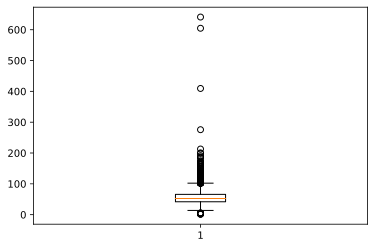

In [29]:
plt.boxplot(train['Square'])
plt.show

In [31]:
train['Square'].quantile(.975), train['Square'].quantile(.025)

(100.90624548226137, 32.10518291149681)

In [37]:
train.loc[train['Square']>train['Square'].quantile(.975), ['DistrictId','Rooms','Square','LifeSquare','KitchenSquare','Social_2',target_name]].sort_values('Square').tail(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Social_2,Price
Id,,,,,,,
15947,129,4.0,185.906396,84.830074,31.0,5613,340273.238253
3233,129,4.0,186.692602,87.487080,32.0,5613,423443.464367
3718,56,3.0,190.857689,107.376164,19.0,5067,338644.075979
4249,23,5.0,198.930182,123.139863,10.0,475,345665.209100
16568,27,4.0,200.334539,201.627361,25.0,14892,528560.506016
7917,27,0.0,212.932361,211.231125,0.0,1892,302211.260887
5548,86,5.0,275.645284,233.949309,26.0,7010,455264.882666
2307,102,1.0,409.425181,410.639749,10.0,3889,90470.430830
28,9,2.0,604.705972,NaN,1.0,5648,187717.242538


* Площадь на комнату

In [53]:
train.loc[train['LifeSquare'].isna()]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,SquareByRoom
Id,,,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,...,0,0,305018.871089,0,1,0,1,0,1,38.342437
2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,...,0,1,168106.007630,0,1,0,1,0,1,40.409907
4581,1,1.0,47.582480,NaN,1.0,16,16.0,1977,0.007122,1,...,0,1,128803.593810,0,1,0,1,0,1,47.582480
8768,63,1.0,50.974891,NaN,1.0,7,16.0,2018,0.238617,26,...,3,6,260328.413376,0,1,0,1,0,1,50.974891
4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,2,...,0,0,135466.559958,0,1,0,1,1,0,44.203947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4944,6,2.0,52.573133,NaN,1.0,18,17.0,1977,0.243205,5,...,0,0,154366.031184,0,1,0,1,0,1,26.286566
4851,1,1.0,39.314342,NaN,1.0,13,17.0,1977,0.007122,1,...,0,1,137782.941940,0,1,0,1,0,1,39.314342
6753,62,2.0,73.092686,NaN,1.0,4,16.0,2017,0.072158,2,...,0,0,159077.198056,0,1,0,1,1,0,36.546343


In [51]:
train.loc[train['Square'].isna()]

train.loc[train['LifeSquare'].notna() & train['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,SquareByRoom
Id,,,,,,,,,,,,,,,,,,,,,
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,...,1,0,177734.553407,0,1,0,1,0,1,39.832524
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,...,3,1,282078.720850,0,1,0,1,0,1,26.114072
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,...,0,6,343995.102962,0,1,0,1,0,1,32.142534
5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,35,...,2,4,161044.944138,0,1,0,1,0,1,20.842822
8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,24,...,0,3,142402.739272,0,1,0,1,0,1,33.938750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,52,...,1,9,119367.455796,0,1,0,1,0,1,24.545364
16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,2,...,0,0,199715.148807,0,1,0,1,1,0,32.153842
2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,20,...,1,5,165953.912580,0,1,0,1,0,1,29.648057


In [47]:
train['LifeSquare'].isna()

Id
11809     True
3013     False
8215     False
2352      True
13866    False
         ...  
1260     False
16265    False
2795     False
14561    False
7202     False
Name: LifeSquare, Length: 10000, dtype: bool

In [39]:
train['SquareByRoom'] = train['Square']/train['Rooms']

In [42]:
train.groupby('DistrictId')['SquareByRoom'].median()

DistrictId
0      31.030143
1      33.183093
2      28.338771
3      28.826026
4      25.042796
         ...    
202    26.277953
205    43.226985
207    25.593653
208    26.930419
209    33.533077
Name: SquareByRoom, Length: 205, dtype: float64

In [44]:
train.loc[train['SquareByRoom']>train['SquareByRoom'].quantile(.975), ['DistrictId','Rooms','Square','LifeSquare','KitchenSquare','Social_2',target_name]].sort_values('Square')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Social_2,Price
Id,,,,,,,
3224,27,0.0,2.377248,0.873147,0.0,469,126596.941798
3159,88,0.0,38.697117,19.345131,9.0,8429,158998.110646
7317,27,0.0,41.790881,NaN,0.0,1892,98129.976788
770,28,0.0,49.483501,NaN,0.0,6207,217009.338463
16268,44,1.0,51.924152,48.723285,12.0,4378,244348.950472
...,...,...,...,...,...,...,...
7917,27,0.0,212.932361,211.231125,0.0,1892,302211.260887
5548,86,5.0,275.645284,233.949309,26.0,7010,455264.882666
2307,102,1.0,409.425181,410.639749,10.0,3889,90470.430830


In [ ]:
train[]